In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-91kkz_06
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-91kkz_06
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


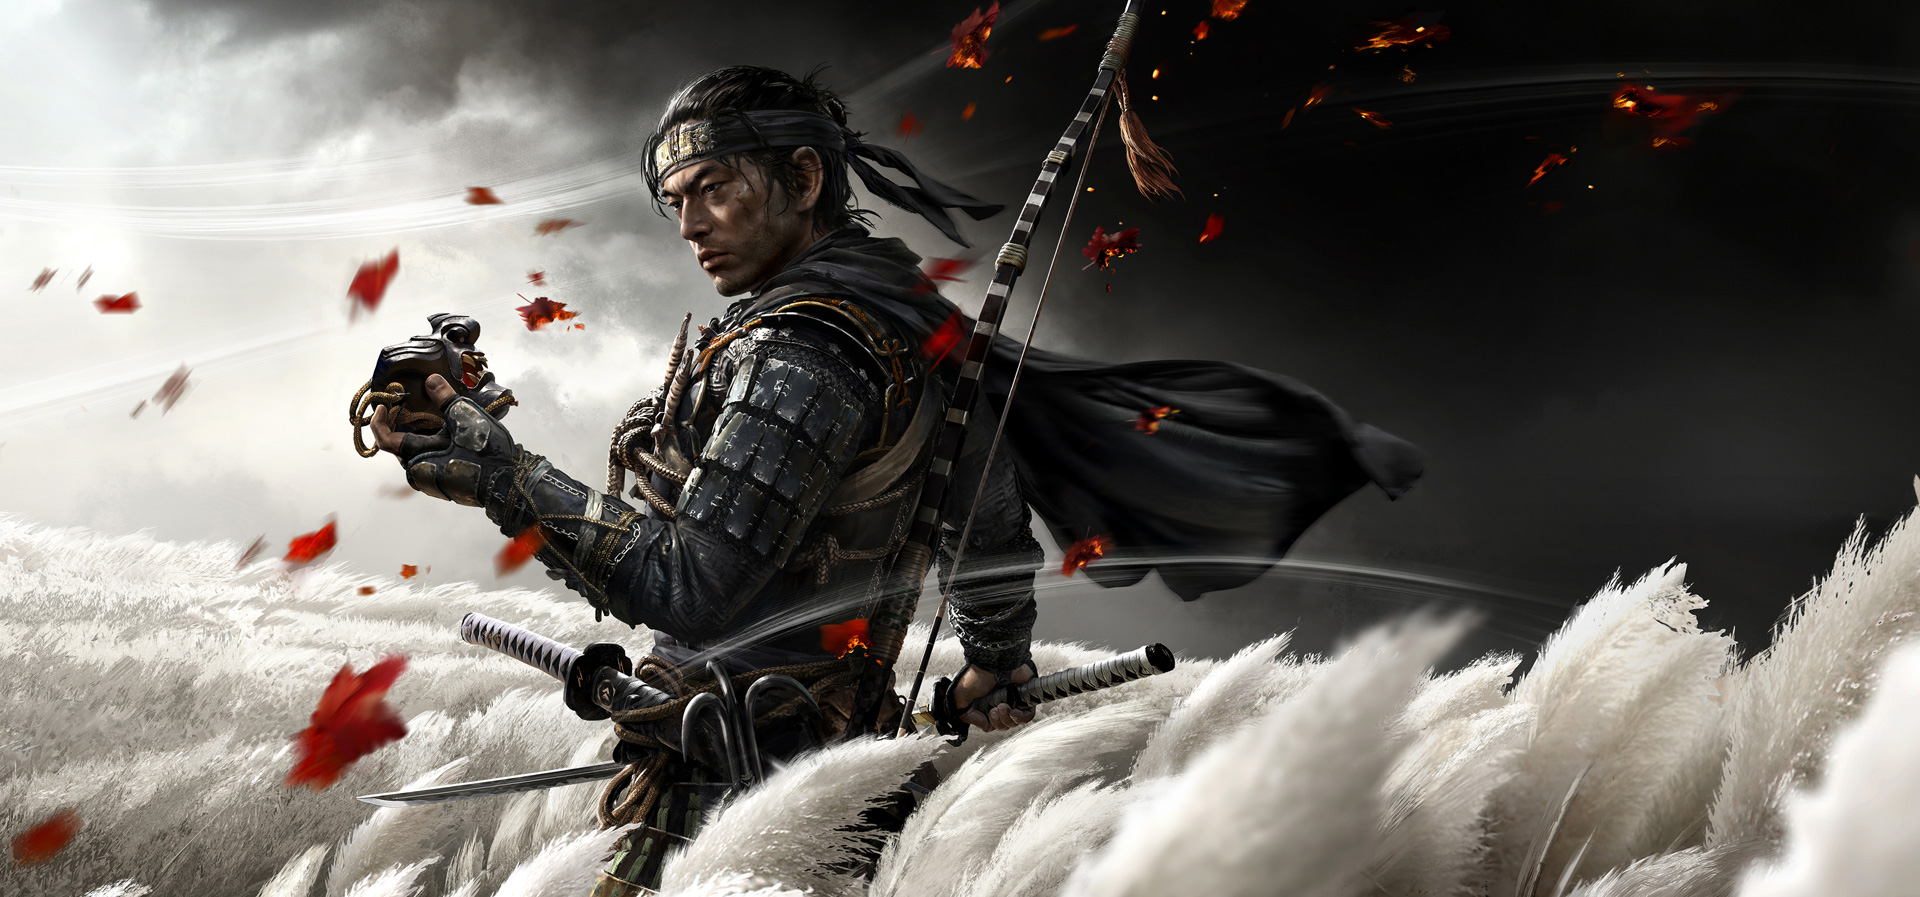

In [11]:
import cv2
from numba import cuda
import sys
from google.colab.patches import cv2_imshow
# Load the image
image = cv2.imread('jinsakai.jpg')
cv2_imshow(image)

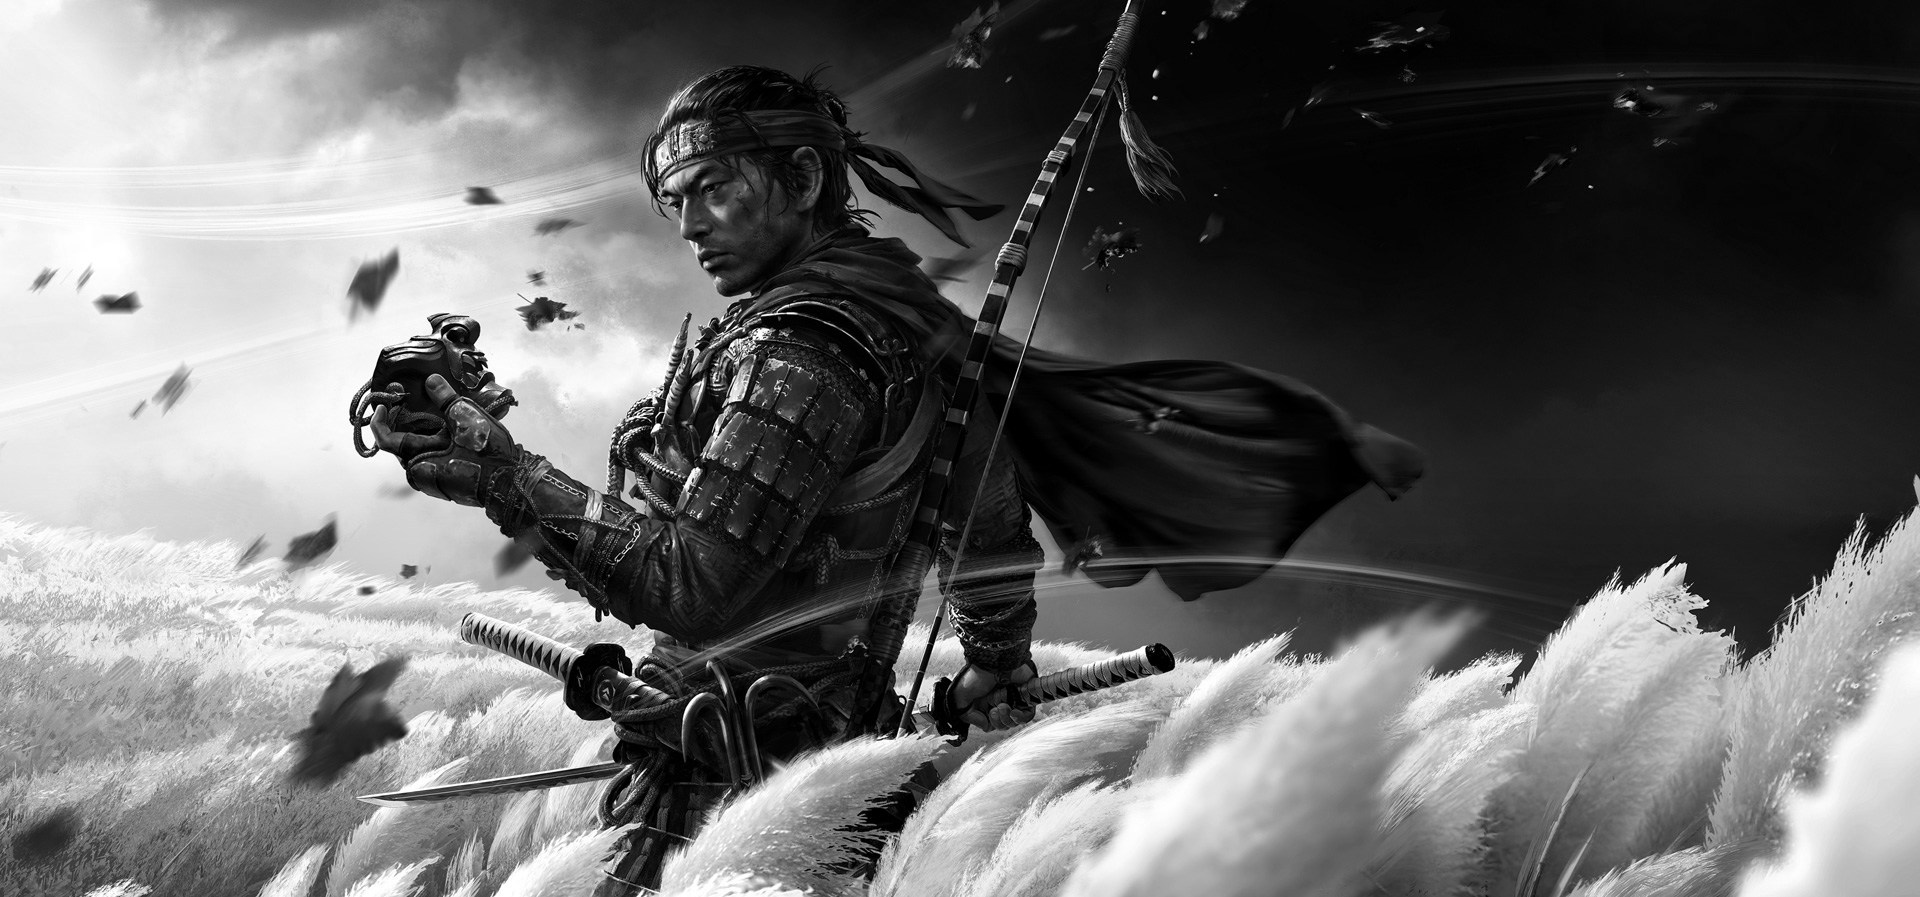

In [12]:
# Check if image loading was successful
if image is None:
    print("Error: Unable to load the input image.")
    sys.exit()

# Convert the image to grayscale using CUDA
@cuda.jit
def gpu_rgb_to_gray(input_image, output_image):
    # Calculate the thread's absolute position within the grid
    x, y = cuda.grid(2)
    if x < input_image.shape[0] and y < input_image.shape[1]:
        # Convert RGB to grayscale (simple average)
        gray_value = (input_image[x, y, 0] + input_image[x, y, 1] + input_image[x, y, 2]) / 3
        output_image[x, y] = gray_value

# Allocate GPU memory for the input and output images
d_input = cuda.to_device(image)
d_output = cuda.device_array((image.shape[0], image.shape[1]), dtype=image.dtype)

# Configure the CUDA kernel
threads_per_block = (16, 16)
blocks_per_grid_x = (image.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (image.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Launch the CUDA kernel
gpu_rgb_to_gray[blocks_per_grid, threads_per_block](d_input, d_output)

# Copy the grayscale image back to the host memory
grayscale_image = d_output.copy_to_host()

# Display or save the grayscale image
cv2_imshow(grayscale_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
